In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Modelagem de sátiras com LDA
# Link dos dados: https://raw.githubusercontent.com/caiolibanio/atividade_NLP/master/csv_satiras_politicas.csv
# O Dataframe tem sátiras em português, assim como seus títulos e textos


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/caiolibanio/atividade_NLP/master/csv_satiras_politicas.csv")
df

,title,text,label
0,crise e tao grande que nem tiozao do pave fez...,a familia guimaraes passou a noite de natal pe...,satire
1,nao me representam diz jesus sobre intolerant...,uma menina de 11 anos apedrejada ao sair de um...,satire
2,marina silva e heloisa helena montam novo par...,insatisfeitas com seus partidos com as siglas ...,satire
3,dez propostas que podem realmente mudar o brasil,o instituto nupal nucleo de pesquisas da ameri...,satire
4,apresentadora do cidade alerta bahia dara cur...,assassinatos sequestros mortes violentas. nen...,satire
...,...,...,...
4369,pesquisa 85 das pessoas ja abandonaram a diet...,ferias de janeiro acabaram carnaval acabou. o...,satire
4370,19h de sexta ja e hora de admitir a derrota e...,sextafeira dia de esperancas no coracao dos so...,satire
4371,senado aprova hoje nova reforma ortografica c...,a lingua portuguesa passara a ser a primeira d...,satire
4372,haddad prova que unica coisa que o pt nao rou...,o prefeito fernando haddad teve que manter a v...,satire


In [3]:
df.text[0]

'a familia guimaraes passou a noite de natal perplexa.  genival o tiozao do pave deles desde 1985 nao fez a tradicional piada quando as sobremesas da ceia chegaram.  dispensou a piada e o pave.  limitouse a se servir de pudim de leite e sentar no sofa mudo.  tambem nao contou piadas sexistas e passou a noite sem qualquer trocadilho idiota. e a crise.  servidor publico estadual genival esta sem receber.  teve que vender seu chevette 89 e nao conseguiu comprar presentes para nenhum dos sobrinhos.  a noite de natal sem a piada do pave ou pacume nao e a mesma diz rafael pereira 21 anos um de seus sobrinhos.  esperamos que ano que vem as coisas melhores e ele volte a fazer essa piada tao idiota porque noite de natal sem piada do pave e pior do que sem rabanada. '

# Preparando o texto: remoção de stopwords, puntuações, dados numéricos, etc.

In [4]:
df.dropna(inplace=True)
df.shape

(4374, 3)

In [5]:
stop_words = set(stopwords.words("portuguese"))

In [6]:
def clean_text(text):
  text = text.lower()
  text = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", text)
  text = re.sub('[,.!?;:/]', '', text)
  text = re.sub('\r\n', ' ',text)
  text = re.sub('\n', ' ',text)
  text = ' '.join(i for i in text.split() if not(i in stop_words) and len(i) > 2 and (not any (c.isdigit() for c in i)))
  return text

In [7]:
df['text'] = df['text'].apply(clean_text)

In [8]:
df.text[0]

'familia guimaraes passou noite natal perplexa genival tiozao pave desdenao fez tradicional piada sobremesas ceia chegaram dispensou piada pave limitouse servir pudim leite sentar sofa mudo tambem nao contou piadas sexistas passou noite qualquer trocadilho idiota crise servidor publico estadual genival receber vender chevettee nao conseguiu comprar presentes nenhum sobrinhos noite natal piada pave pacume nao mesma diz rafael pereiraanos sobrinhos esperamos ano vem coisas melhores volte fazer piada tao idiota porque noite natal piada pave pior rabanada'

In [9]:
df.head(5)

,title,text,label
0,crise e tao grande que nem tiozao do pave fez...,familia guimaraes passou noite natal perplexa ...,satire
1,nao me representam diz jesus sobre intolerant...,menina deanos apedrejada sair festa candomble ...,satire
2,marina silva e heloisa helena montam novo par...,insatisfeitas partidos siglas partidos politic...,satire
3,dez propostas que podem realmente mudar o brasil,instituto nupal nucleo pesquisas america latin...,satire
4,apresentadora do cidade alerta bahia dara cur...,assassinatos sequestros mortes violentas nenhu...,satire


# Word Cloud

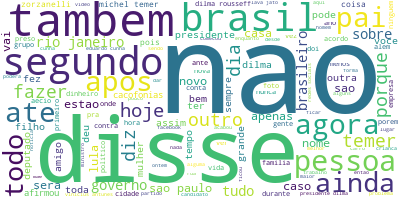

In [10]:
long_string = ','.join(list(df['text'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

# Vectorizer - CountVectorizer

In [11]:
tf_vectorizer = CountVectorizer(
        min_df = 30,
        max_df = 0.5,
        max_features = 10000,
        stop_words = stop_words, 
        ngram_range = (1,2)
)

vec_text = tf_vectorizer.fit_transform(df.text)
words = tf_vectorizer.get_feature_names()
print(vec_text.shape)
print(len(words))

(4374, 1926)
1926


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
words[0:10]

['abaixo',
 'aberta',
 'abertura',
 'abrir',
 'abriu',
 'absurdo',
 'acaba',
 'acabar',
 'acabaram',
 'acabou']

# LDA 

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

In [14]:
def print_top_words(model, feature_names, n_top_words):
  for topic_idx, topic in enumerate(model.components_):
    print(f"\n--\nTopic #{topic_idx + 1}: ")
    message = ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)
  print()

In [15]:
def display_topics(W, H, feature_names, documents, no_top_words, no_top_documents):
  for topic_idx, topic in enumerate(H):
    print(f"\n--\nTopic #{topic_idx + 1}: ")
    print(", ".join([feature_names[i]
      for i in topic.argsort()[:-no_top_words - 1:-1]]).upper())

    top_d_idx = np.argsort(W[:,topic_idx])[::-1][0:no_top_documents]
    for d in top_d_idx:
      doc_data = df[['title']].iloc[d]
      print(f'{doc_data[0]} : \t{W[d, topic_idx]:.2f}')

In [16]:
lda = LatentDirichletAllocation(n_components=10,  # número de tópicos que vamos tentar descobrir
                                max_iter = 5,
                                learning_method='online', # caso online, demorará menos e irá usar um conjunto de dados menor
                                random_state=0)

lda.fit(vec_text)
doc_topic_matrix = lda.transform(vec_text)

In [17]:
print('Matriz documento-tópicos:' + str(doc_topic_matrix.shape))
print('Matriz tópicos-termos:' + str(lda.components_.shape))

Matriz documento-tópicos:(4374, 10)
Matriz tópicos-termos:(10, 1926)


# Analisando os tópicos

In [18]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names,15)


--
Topic #1: 
nupal, pesquisas, pesquisa, america, estudo, latina, america latina, nucleo, pesquisas america, nucleo pesquisas, pessoas, mostrou, instituto, instituto nupal, levantamento

--
Topic #2: 
mulher, pessoas, disse, semana, dois, agora, diz, hoje, novo, internet, sobre, tambem, homem, marcelo, mulheres

--
Topic #3: 
sao, paulo, sao paulo, onibus, premio, papa, francisco, obra, evento, maiores, igreja, sendo, academia, porem, pessoal

--
Topic #4: 
disse, tambem, ate, brasil, pais, ter, presidente, apos, pode, hoje, sobre, vai, dilma, dia, zorzanelli

--
Topic #5: 
lula, disse, expresidente, ter, apos, casa, ainda, juiz, hoje, moro, segundo, sido, brasil, amigo, sergio

--
Topic #6: 
temer, presidente, dilma, michel, michel temer, governo, disse, jato, lava, lava jato, palacio, prisao, planalto, operacao, eike

--
Topic #7: 
federal, disse, tambem, ministro, governo, policia, dinheiro, pais, politicos, stf, justica, ter, temer, brasil, presidente

--
Topic #8: 
rio, janeiro,

In [19]:
display_topics(
  doc_topic_matrix,
  lda.components_, 
  words,
  df,
  10, 
  5
)


--
Topic #1: 
NUPAL, PESQUISAS, PESQUISA, AMERICA, ESTUDO, LATINA, AMERICA LATINA, NUCLEO, PESQUISAS AMERICA, NUCLEO PESQUISAS
 trabalhar no dia do trabalho nao garante estar namorando no dia dos namorados : 	0.85
 musica gospel alta so faz jesus ser xingado pelos vizinhos diz pesquisa : 	0.78
 estudo revela que homens com coque sao mais atraentes para outros homens : 	0.78
 fins de semana nos quais voce tem que trabalhar sao sempre os mais ensolarados diz estudo : 	0.78
 90 das pessoas nao sabem percentual 15 sabem : 	0.76

--
Topic #2: 
MULHER, PESSOAS, DISSE, SEMANA, DOIS, AGORA, DIZ, HOJE, NOVO, INTERNET
 e possivel dar manchetes de violencia contra a mulher nos outros 364 dias do ano diz estudo : 	0.99
 ladrao assaltado depois de roubar farmacia sai da cadeia e vai ao japao ver o corinthians : 	0.94
 tumulto para entrar no supermercado guanabara era pra ficar no ar condicionado : 	0.79
 familia de leslie nielsen agradece traficantes da vila cruzeiro por homenagem a corra que a po

In [20]:
main_topic = []
mt_prob = []
for l in range(len(df['title'])):
  main_topic.append(doc_topic_matrix[l,:].argmax() + 1)
  mt_prob.append(doc_topic_matrix[l,:].max())

df = df.assign(main_topic = main_topic, main_topic_prob = mt_prob)

In [21]:
df.head()

,title,text,label,main_topic,main_topic_prob
0,crise e tao grande que nem tiozao do pave fez...,familia guimaraes passou noite natal perplexa ...,satire,8,0.556490
1,nao me representam diz jesus sobre intolerant...,menina deanos apedrejada sair festa candomble ...,satire,4,0.578639
2,marina silva e heloisa helena montam novo par...,insatisfeitas partidos siglas partidos politic...,satire,5,0.598170
3,dez propostas que podem realmente mudar o brasil,instituto nupal nucleo pesquisas america latin...,satire,1,0.699652
4,apresentadora do cidade alerta bahia dara cur...,assassinatos sequestros mortes violentas nenhu...,satire,4,0.886530


In [22]:
topico = 7
pd.options.display.max_colwidth = 300
df[df['main_topic'] == topico].sort_values('main_topic_prob', ascending = False)[['main_topic_prob','title', 'text']].head(20).sample(10)

,main_topic_prob,title,text
103,0.952563,eduardo campos procura medium para fazer delacao premiada,durante operacao turbulencia policia federal apontou empresario joao carlos lyra pessoa melo filho encarregado entregar propina camargo correa excandidato presidencia eduardo campos senador fernando coelho bezerra pai ministro minas energia governo temer fernando filho acordo policia federal lyr...
173,0.752285,stf decide se renan e culpado ou nao e inocente,supremo tribunal federal reune hoje debater questao importante dividindo pais metade acha renan calheiros culpado outra acha nao inocente presidente senado sendo acusado peculato desviar dinheiro publico uso particular outra acusacao falsidade ideologica senador usado empreiteira mendes junior p...
1429,0.734950,carteira de motoristas para babacas vai permitir que eles so andem pelo acostamento,denatran vai criar nova categoria carteira motorista especial babacas partir semana vem declarar babaca hora renovar carteira ganhara nova habilitacao documento permitira babaca circule acostamentos buzine incessantemente ande farol alto encoste traseira forcar passagem outras manobras resolvemo...
397,0.730953,stf deixa renan na presidencia do senado porque papeis do amigo oculto ja foram tirados,apos vencer stf seis votos tres renan calheiros continua sendo presidente senado deixa fazer parte linha sucessoria presidencia pais seis ministros votaram permanencia renan derrubaram liminar pediu afastamento senador ultima segundafeira acordo presentes real motivo votos favor renan amigo ocul...
411,0.892616,senado desafia stf e passa superbonder na cadeira de renan,mesa diretora senado decidiu nao acatar liminar supremo tribunal federal manteve renan calheiros presidencia senadores optaram aguardar votacao final stf vez respeitar liminar ministro marco aurelio mello decisao brasil passa monarquia rainha inglaterra stf senadores empolgados decidiram desafia...
295,0.747750,pf desconfia que pmdb e organizacao criminosa e que chapolin seja o chaves,policia federal concluiu inquerito apura integrantes pmdb camara formaram organizacao criminosa desviar recursos publicos investigadores encontraram indicios formacao organizacao criminosa envolvem presidente michel temer exdeputados eduardo cunha henrique alves exministro geddel vieira lima min...
109,0.835698,apos stf aceitar moreira ministro e com foro velorio da lava jato e marcado para as 14h,ministro celso mello decidiu ontem contra liminar impedia moreira franco gato angora lista odebrecht assumir posto ministro ter foro privilegiado governo temer moreira citado devezes delacoes odebrecht jurisprudencia caso lula barrado gilmar mendes assumir chefia casa civil investigado lava jato...
17,0.771976,mpf diz que organizadores da olimpiada usaram anabolizantes na propina,policia federal executou hoje acao lava jato rio janeiro chamada unfair play investiga compra jurados eleicao cidade sede olimpiada dee levou presidente cob carlos arthur nuzman depor delegacia ministerio publico federal pediu bloqueio debilhao reais nuzman empresarios arthur cesar soares meneze...
1313,0.767091,apos suspender transferencia de cabral gilmar pede doces para nao fazer mais travessuras,ministro gilmar mendes stf suspendeu hoje decisao justica federal rio janeiro havia determinado transferencia exgovernador sergio cabral presidio federal campo grande mato grosso sul transferencia pedido ministerio publico federal cabral fez comentarios sobre atividade empresarial familia juiz m...
3426,0.785090,pernilongo ganha na justica direito de transmissao da zika,mosquito culex popularmente conhecido pernilongo acaba obter vitoria justica artropode conseguiu liminar permite transmitir virus zika todo territorio nacional liminar concedida juiz adalberto ferrao camara civel pernilongo comemorou quebra monopolio aedes aegipty transmissao virus agora advogad...


In [23]:
topicnames = ["Topic {}".format(i + 1) for i in range(doc_topic_matrix.shape[1])]

satira_topico = pd.DataFrame(np.round(doc_topic_matrix, 2), columns=topicnames, index = df.index)
satira_topico[['title']] = df[['title']]

ordem = ['title']
ordem.extend(topicnames)
satira_topico = satira_topico[ordem]

# Visualizando cada tópico

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [25]:
pyLDAvis.sklearn.prepare(lda, vec_text, tf_vectorizer, sort_topics=False, mds = 'tsne')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1   3.226467
1       0.648955  71.707100       2        1  10.224684
2      71.019684   9.971006       3        1   3.038973
3       3.785981  33.185135       4        1  21.206485
4     -42.666500  -9.222070       5        1  13.421336
5      -3.621689 -43.526516       6        1   7.015234
6      -3.632402  -4.171708       7        1  11.924560
7     -36.584400  35.804413       8        1  15.023317
8      44.391380  50.615383       9        1  10.121157
9      40.235809 -31.591665      10        1   4.797786, topic_info=           Term         Freq        Total Category  logprob  loglift
1620        sao  1343.000000  1343.000000  Default  30.0000  30.0000
1742      temer  1300.000000  1300.000000  Default  29.0000  29.0000
1283      paulo   698.000000   698.000000  Default  28.0000  28.0000
42        aecio   637.000000   637.000000  Default  27.0000  27.0000
1621  sao paulo   559.000000   559.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
529       disse   154.318140  3019.022642  Topic10  -4.2249   0.0633
1846        vai   114.426203  1066.959767  Topic10  -4.5240   0.8044
1634    segundo   111.656058  1294.349653  Topic10  -4.5485   0.5867
555        dois    72.859851   485.358396  Topic10  -4.9754   1.1407
1620        sao    76.416329  1343.149637  Topic10  -4.9277   0.1704

[618 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
7         2  0.700400      acabar
7         3  0.293330      acabar
9         1  0.009251      acabou
9         2  0.425524      acabou
9         3  0.003084      acabou
...     ...       ...         ...
1925      5  0.086350  zorzanelli
1925      6  0.009089  zorzanelli
1925      7  0.102256  zorzanelli
1925      9  0.118163  zorzanelli
1925     10  0.018179  zorzanelli

[1579 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])